In [1]:
#imports
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run dataloader.ipynb

In [3]:
batch_size=2600
train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1000, shuffle=True)

In [4]:
gpu_id = 'cuda:2'
device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')

In [5]:
# rnn
class RNN(torch.nn.Module):

    def __init__(self, input_dim_text, input_dim_speech, hidden_layer_size) -> None:
        super().__init__()

        self.text_rnn = torch.nn.LSTM(input_dim_text, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.speech_rnn = torch.nn.LSTM(input_dim_speech, hidden_layer_size, batch_first=True, num_layers=2, dropout=0.2)
        self.dropout = torch.nn.Dropout(0.2)
        self.linear = torch.nn.Linear(hidden_layer_size, 1)

    def forward(self, x_text, x_speech, text_lens):
        batch_size = x_text.shape[0]

        interm_states_text, _ = self.text_rnn(x_text)
        interm_states_speech, _ = self.speech_rnn(x_speech)

        final_state_text = interm_states_text[torch.arange(batch_size), text_lens - 1, :]
        final_state_speech = interm_states_speech[torch.arange(batch_size), text_lens - 1, :]

        stacked = torch.stack((
            final_state_text, 
            final_state_speech
            ), dim=1)
        pooled = torch.max(stacked, dim=1)[0]
        h = self.dropout(pooled)
        return self.linear(h)

step error


/tmp/ipykernel_3413152/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3413152/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3413152/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

1 0.6924474239349365
dev error:  0.6923143863677979
2 0.6922346353530884
dev error:  0.691839873790741
3 0.6909096240997314
dev error:  0.6910250186920166
4 0.6899012923240662
dev error:  0.6899558305740356
5 0.6880752444267273
dev error:  0.6884116530418396
6 0.6858342289924622
dev error:  0.6859463453292847
7 0.6793818473815918
dev error:  0.6816891431808472
8 0.6654880046844482
dev error:  0.6764957904815674
9 0.658271074295044
dev error:  0.6739716529846191
10 0.6527717113494873
dev error:  0.6782445907592773
11 0.6661831140518188
dev error:  0.6716827154159546
12 0.6425116062164307
dev error:  0.6655011773109436
13 0.6436248421669006
dev error:  0.6650757193565369
14 0.6347373127937317
dev error:  0.6629274487495422
15 0.6349993944168091
dev error:  0.6641308069229126
16 0.6340296864509583
dev error:  0.6601534485816956
17 0.6316373944282532
dev error:  0.6576272249221802
18 0.6342479586601257
dev error:  0.6569578051567078
19 0.6299755573272705
dev error:  0.6621955633163452
20 0

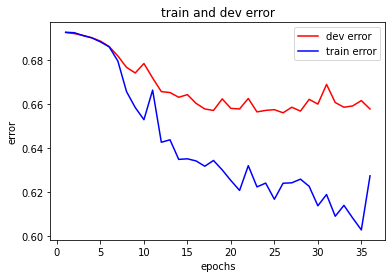

best model after 26 epochs with dev set error 0.6558867692947388


In [6]:
# input features
###
idxs_text = torch.arange(300) # text, 300
idxs_speech = torch.arange(300, 381) # speech, 81

device = torch.device(gpu_id if torch.cuda.is_available() else 'cpu')
model = RNN(input_dim_text=300, input_dim_speech=81, hidden_layer_size=256)
model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002)
epochs = 100
patience = 10

print('step', 'error')
dev_errors = []
best_dev_error = np.inf
errors = []
num_bad_epochs = 0
num_epochs = 0
best_epoch = 0
for epoch in range(1, epochs+1):
    model.train()
    for batch_idx, batch in enumerate(train_dataloader, 0):
        x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
        optimiser.zero_grad()
        output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        error.backward()
        optimiser.step()
    
    print(epoch, error.detach().tolist())
    errors.append(error.detach().tolist())

    with torch.no_grad():
        model.eval()
        matches = 0
        total = 0
        for batch_idx, batch in enumerate(dev_dataloader, 0):
            x_p,x_c,y,hid,x_p_len=map(lambda x: x.to(device), batch)
            dev_output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p_len)
            dev_error = torch.nn.functional.binary_cross_entropy_with_logits(dev_output, y)
        dev_errors.append(float(dev_error))
        print('dev error: ', float(dev_error))

    if dev_error < best_dev_error:
        num_bad_epochs = 0
        best_dev_error = dev_error
        best_epoch = epoch
        torch.save(model, 'punchline_net_text-speech.pth')
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            num_epochs = epoch
            break

plt.plot(range(1, num_epochs+1), dev_errors, 'r', label='dev error')
plt.plot(range(1, num_epochs+1), errors, 'b', label='train error')
plt.title('train and dev error')
plt.xlabel('epochs')
plt.ylabel('error')
plt.legend()
plt.show()

print('best model after {} epochs with dev set error {}'.format(best_epoch, best_dev_error))
model = torch.load('punchline_net_text-speech.pth')

In [9]:
hid_humor_t = {}
hid_humor_f = {}
hid_nonhumor_t = {}
hid_nonhumor_f = {}

with torch.no_grad():
    matches = 0
    total = 0
    for batch_idx, batch in enumerate(test_dataloader, 0): 
        x_p,x_c,y,hid, x_p_len=map(lambda x: x.to(device), batch)
        output = model(x_p[:, :, idxs_text], x_p[:, :, idxs_speech], x_p_len)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, y)
        scaled_outputs = torch.sigmoid(output)
        predictions = (scaled_outputs > 0.5)*1
        matches += (y == predictions).sum()
        total += len(y)
        for j, id in enumerate(hid.detach().tolist()):
            if predictions[j] == 1 and y[j] == 1:
                hid_humor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 1 and y[j] == 0:
                hid_humor_f[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 0:
                hid_nonhumor_t[id] = scaled_outputs[j].detach().tolist()[0]
            elif predictions[j] == 0 and y[j] == 1:
                hid_nonhumor_f[id] = scaled_outputs[j].detach().tolist()[0]
            else:
                print('something is wrong')
    acc = matches / total
    print('test error: ', float(error))
    print('test accuracy: {:.2%}'.format(float(acc)))

/tmp/ipykernel_3413152/4016921915.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_w=np.array(self.language_sdk[hid]['context_embedding_indexes'])
/tmp/ipykernel_3413152/4016921915.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  context_of=np.array(self.word_aligned_openface_sdk[hid]['context_features'])
/tmp/ipykernel_3413152/4016921915.py:104: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you 

test error:  0.639680027961731
test accuracy: 64.29%


In [8]:
print(len(hid_humor_t))
print(len(hid_nonhumor_t))
print(len(hid_humor_f))
print(len(hid_nonhumor_f))

language_sdk=load_pickle("language_sdk.pkl")

sorted_humor_t = {k: v for k, v in sorted(hid_humor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_t = {k: v for k, v in sorted(hid_nonhumor_t.items(), key=lambda item: item[1], reverse=True)}
sorted_humor_f = {k: v for k, v in sorted(hid_humor_f.items(), key=lambda item: item[1], reverse=True)}
sorted_nonhumor_f = {k: v for k, v in sorted(hid_nonhumor_f.items(), key=lambda item: item[1], reverse=True)}

for hid, output in list(sorted_humor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_humor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_t.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])
print()
for hid, output in list(sorted_nonhumor_f.items())[:5]:
    print(language_sdk[hid]['punchline_sentence'])

326
304
186
164
so had the graduate heard the right one word maybe he would have ended up onstage oh i don't know maybe with these two
and as the saying goes when angry you will make the best speech you will ever regret
no slouching no pants hanging down none of that stuff
this mouthing behavior on the right was really her way of saying to him hey look how big i am or you know my what big teeth you have
i'm going to go ahead and say it out loud anyway are hideous

oh let me kind of tell you a funny little play bit
it's also good news if you want to browse for illegal pornography and if you want to buy and sell drugs with impunity
so when you're watching a movie and a phone rings it's not actually ringing
so even though china's is a totally censored internet but still chinese internet society is really booming
but on the other side of that predatory gaze is a female husky in a play bow wagging her tail

let me just give you an example from a recent study that we conducted
many of you ha